# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
#import plotly.express as px

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',';')

# Load in the feature summary file.
    # Feature summary file contains very useful information about the data types for each feature
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',';')

In [3]:
azdias.shape

(891221, 85)

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.shape

(85, 4)

In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Count of Total NaN
azdias.isna().sum().sum()

4896838

In [8]:
type(feat_info['missing_or_unknown'][0])

str

Currently 'missing_or_unknown' is a STR that needs to be converted to list of INT

In [9]:
# Using this function to convert the strings of a list to actual lists
def string_to_list(x):
    '''
    This function takes a string of a list and returns a list containing integers and strings.
    Note the list can only contain alphanumeric values for it to work.
    
    Input: String of a list (i.e. '[1,2,XX]')
    Returns: List data type
    '''
    new_list=[]
    # The below line removes the '[]' and splits on ',', creating a list of strings
    x = x[1:-1].split(',')
    # For each value in the list of strings, try turning it into an integer if possible and append to new_list
        # Otherwise, append it to new_list
    for i in x:
        try:
            new_list.append(int(i))
        except:
            new_list.append(i)
    return new_list

In [10]:
# Applying the function
feat_info['NA_tags'] = feat_info['missing_or_unknown'].apply(string_to_list)

In [11]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown,NA_tags
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [12]:
type(feat_info['missing_or_unknown'][0])

str

In [13]:
att_index = feat_info.set_index('attribute')

In [14]:
# Demographics data copy to work with to be the version with NA's inserted
na_azdias = azdias[:]

In [15]:
# Looping through our column names
for column in na_azdias.columns:
    # For every column in our DF, if a value is in the 'NA_tags' list, we replace it inplace with np.NaN
    na_azdias[column].replace(att_index.loc[column].loc['NA_tags'],np.NaN,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [16]:
na_azdias.isna().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Amount of NaN per column
na_azdias.isna().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [18]:
null_sum = na_azdias.isna().sum()
null_sum.reset_index()

,index,0
0,AGER_TYP,685843
1,ALTERSKATEGORIE_GROB,2881
2,ANREDE_KZ,0
3,CJT_GESAMTTYP,4854
4,FINANZ_MINIMALIST,0
5,FINANZ_SPARER,0
6,FINANZ_VORSORGER,0
7,FINANZ_ANLEGER,0
8,FINANZ_UNAUFFAELLIGER,0
9,FINANZ_HAUSBAUER,0


In [19]:
null_percent = null_sum[null_sum > 0]/na_azdias.shape[0] * 100
null_percent.sort_values(inplace=True)

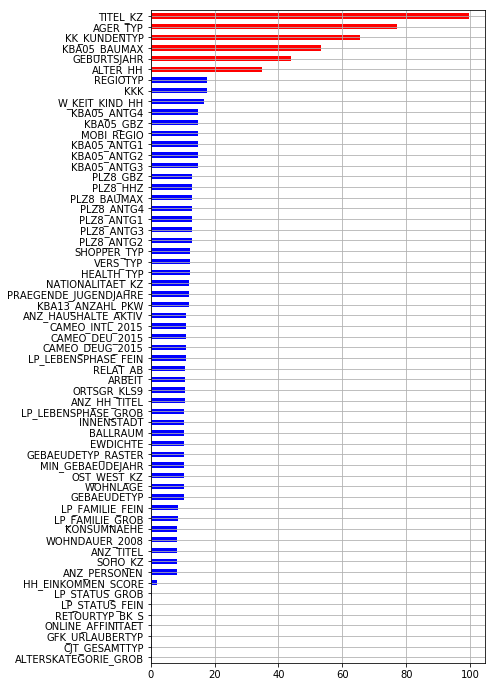

outlier_columns:  ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In [20]:
color = ['red' if i > 25 else 'blue' for i in null_percent]
null_percent.plot.barh(figsize=(6,12), color = color)
plt.grid(True)
plt.show()

outlier_columns = null_percent.index[null_percent>25].tolist()[::-1]

print("outlier_columns: ", outlier_columns)

In [21]:
outlier_columns = ['KBA05_BAUMAX','KK_KUNDENTYP','ALTER_HH','TITEL_KZ','GEBURTSJAHR','AGER_TYP']

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

na_azdias.drop(labels=outlier_columns,axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
na_azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

There were six columns identified as `'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'`, that had more than 25% of thier data be missing/NaN/0. Digging into the Data_dictionary attached I identified what these columns did and believe they are incomplete and unimportant enough to warrant dropping:

**TITEL_KZ**: Academic title flag
> If has title of "Dr"

**AGER_TYP**: Best-ager typology
> Anything above '0' is "elderly"

**KK_KUNDENTYP**: Consumer pattern over past 12 months
> Consumer pattern over past 12 months: "regular", "active", "new", etc

**KBA05_BAUMAX**: Most common building type within the microcell
> appears to reference residences in geographic area: X - Y # family homes in 'micro cell' area, or 'mainly business'

**GEBURTSJAHR**: Year of birth
> Lots missing

**ALTER_HH**: Birthdate of head of household
> 5 year increments from 1895 to 2000

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?
na_azdias['no_na_row'] = na_azdias.isna().sum(axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


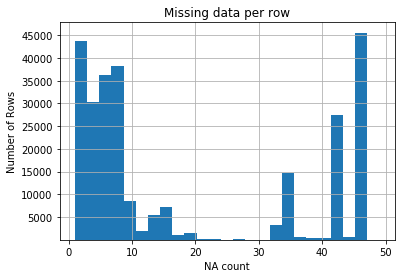

In [25]:
plt.hist(na_azdias[na_azdias['no_na_row']>0]['no_na_row'],bins=25)
plt.xlabel('NA count')
plt.ylabel('Number of Rows')
plt.yticks()
plt.yticks([5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000])
plt.title('Missing data per row')
plt.grid(True)

plt.show()

Looking at the comparison of data lost against number of rows dropped withe increase NaN values, there is negligable difference between dropping rows with >= 24 NaN values and >= 33 NaN values (Out of almost 900K total rows, only 571 additional rows would get dropped for an additional loss of .06% of the data.)

In summation if you're gonna drop rows with 33+ NaN values, there's negligable difference instead to drop rows with 24+ NaN values.

I found dropping 24 rows gets rid of 'OST_WEST_KZ' later in the customer data which causes errors in the formatting def run. Using the bar chart above,   I'm going to drop above 30 rows to prevent that issue.

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
na_azdias_b30 = na_azdias[na_azdias['no_na_row']<=30]
na_azdias_g30 = na_azdias[na_azdias['no_na_row']>30]

In [27]:
def compare_columns(df1,df2,column,df1_desc=None,df2_desc=None):
    '''
    Takes two DataFrames and a column name as input and plots two countplots of the given column for both DataFrames.
    '''
    # Taking max value count between the 2 columns to set as ylim for both plots
    df1_max = df1[column].value_counts().iloc[0]
    df2_max = df2[column].value_counts().iloc[0]
    if df1_max > df2_max:
        top = df1_max * 1.05
    else:
        top = df2_max * 1.05
    
    # Plotting
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3))
    sns.countplot(df1[column],ax=ax1)
    ax1.set_ylabel('Count')
    ax1.set_ylim(top=top)
    ax1.set_title(df1_desc)
    sns.countplot(df2[column],ax=ax2)
    ax2.set_ylabel('Count')
    ax2.set_ylim(top=top)
    ax2.set_title(df2_desc)
    plt.tight_layout()

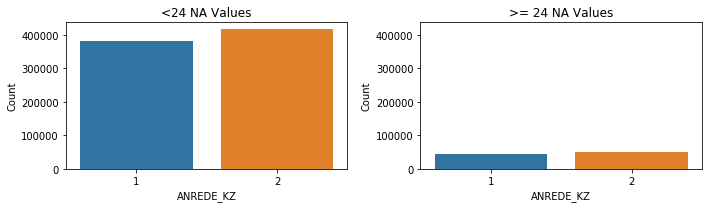

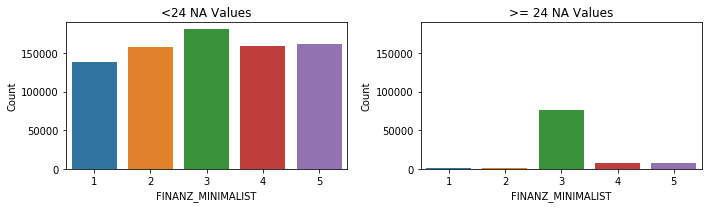

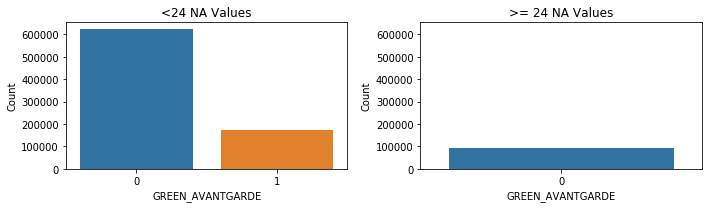

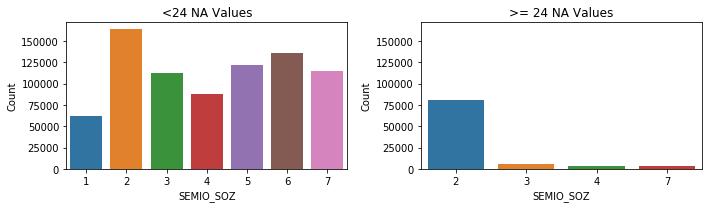

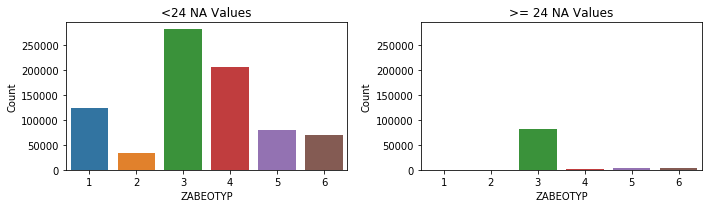

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

full_columns = ['ANREDE_KZ','FINANZ_MINIMALIST','GREEN_AVANTGARDE','SEMIO_SOZ','ZABEOTYP']
for n in full_columns:
    compare_columns(na_azdias_b30,na_azdias_g30,n,"<24 NA Values",">= 24 NA Values")

In [29]:
prop_g_30 = len(na_azdias_g30)/len(na_azdias)
print(f'{prop_g_30*100:.2f}% of our data has more than 30 missing values in a row.')

10.45% of our data has more than 30 missing values in a row.


In [30]:
na_azdias_b30.drop('no_na_row',inplace=True,axis=1)
azdias_1 = na_azdias_b30[:]

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Discussion 1.1.3: Assess Missing Data in Each Row

The rows with >30 NaN values have a lower completeness with less variance in distribution of the data than the rows with <24 NaN values. The key take away is that in some categories, by dropping rows with >= 30 NaN values, we'll be losing approximately 1/3 of the data points in some categories (such as SEMIO_SOZ). This is something to take into account during different, more comprehensive analysis and training of the data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
feat_info = feat_info.set_index('attribute').drop(outlier_columns).reset_index()

In [32]:
# feat_info.head()

In [33]:
# This displays features of each data type
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [34]:
df_dtype = {}
dtypes = ['ordinal','categorical','numeric','mixed']
for d in dtypes:
    df_dtype[d]=feat_info[feat_info['type']==d]['attribute']

In [35]:
df_dtype['categorical']

1            ANREDE_KZ
2        CJT_GESAMTTYP
9            FINANZTYP
10     GFK_URLAUBERTYP
11    GREEN_AVANTGARDE
15     LP_FAMILIE_FEIN
16     LP_FAMILIE_GROB
17      LP_STATUS_FEIN
18      LP_STATUS_GROB
19    NATIONALITAET_KZ
36         SHOPPER_TYP
37             SOHO_KZ
38            VERS_TYP
39            ZABEOTYP
47         GEBAEUDETYP
50         OST_WEST_KZ
52     CAMEO_DEUG_2015
53      CAMEO_DEU_2015
Name: attribute, dtype: object

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [36]:
def check_unique_vals(df):
    for col in df.columns:
        values = list(df[col].unique())
        print(f'{col}: {values}')

In [37]:
check_unique_vals(azdias_1[df_dtype['ordinal']])

ALTERSKATEGORIE_GROB: [1.0, 3.0, 4.0, 2.0, nan]
FINANZ_MINIMALIST: [1, 4, 3, 2, 5]
FINANZ_SPARER: [5, 4, 2, 3, 1]
FINANZ_VORSORGER: [2, 1, 5, 4, 3]
FINANZ_ANLEGER: [5, 2, 1, 4, 3]
FINANZ_UNAUFFAELLIGER: [4, 3, 1, 2, 5]
FINANZ_HAUSBAUER: [5, 2, 3, 4, 1]
HEALTH_TYP: [3.0, 2.0, 1.0, nan]
RETOURTYP_BK_S: [1.0, 3.0, 2.0, 5.0, 4.0, nan]
SEMIO_SOZ: [5, 4, 6, 2, 7, 3, 1]
SEMIO_FAM: [4, 1, 5, 7, 2, 6, 3]
SEMIO_REL: [4, 3, 2, 7, 5, 1, 6]
SEMIO_MAT: [3, 1, 2, 4, 7, 5, 6]
SEMIO_VERT: [1, 4, 7, 2, 6, 5, 3]
SEMIO_LUST: [2, 4, 6, 7, 3, 1, 5]
SEMIO_ERL: [2, 6, 7, 4, 5, 1, 3]
SEMIO_KULT: [3, 4, 6, 5, 7, 1, 2]
SEMIO_RAT: [6, 4, 3, 2, 7, 5, 1]
SEMIO_KRIT: [4, 7, 3, 1, 5, 6, 2]
SEMIO_DOM: [7, 4, 2, 1, 5, 6, 3]
SEMIO_KAEM: [4, 7, 5, 2, 3, 6, 1]
SEMIO_PFLICHT: [7, 3, 4, 5, 1, 6, 2]
SEMIO_TRADV: [6, 3, 4, 2, 7, 5, 1]
HH_EINKOMMEN_SCORE: [6.0, 4.0, 1.0, 5.0, 3.0, 2.0]
W_KEIT_KIND_HH: [3.0, nan, 2.0, 6.0, 5.0, 4.0, 1.0]
WOHNDAUER_2008: [9.0, 8.0, 3.0, 4.0, 5.0, 6.0, 2.0, 7.0, 1.0]
KONSUMNAEHE: [1.0, 5.0, 4.0, 

In [38]:
# Columns that are tagged as "categorical" are either binary or multi_level
# Printing and tracking binary and multi-level categorical values 
binary_cats = []
multi_level_cats = []
for col in azdias_1[df_dtype['categorical']]:
    values = azdias_1[df_dtype['categorical']][col].nunique()
    if values == 2:
        binary_cats.append(col)
    else:
        multi_level_cats.append(col)
    print(f'{col}: {values}')

ANREDE_KZ: 2
CJT_GESAMTTYP: 6
FINANZTYP: 6
GFK_URLAUBERTYP: 12
GREEN_AVANTGARDE: 2
LP_FAMILIE_FEIN: 11
LP_FAMILIE_GROB: 5
LP_STATUS_FEIN: 10
LP_STATUS_GROB: 5
NATIONALITAET_KZ: 3
SHOPPER_TYP: 4
SOHO_KZ: 2
VERS_TYP: 2
ZABEOTYP: 6
GEBAEUDETYP: 7
OST_WEST_KZ: 2
CAMEO_DEUG_2015: 9
CAMEO_DEU_2015: 44


In [39]:
azdias_1[binary_cats].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
3,2,0,0.0,1.0,W
4,1,0,0.0,2.0,W
5,2,0,0.0,2.0,W


In [40]:
azdias_1['OST_WEST_KZ'].value_counts()

W    629525
O    168542
Name: OST_WEST_KZ, dtype: int64

In [41]:
# Re-encode categorical variable(s) to be kept in the analysis.
# pd.get_dummies will sort out this non-numeric binary cat by adding it to multi-level cats list
multi_level_cats.append('OST_WEST_KZ')

In [42]:
azdias_1[multi_level_cats].head()

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015,OST_WEST_KZ
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,8.0,8,8A,W
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,1.0,4,4C,W
3,2.0,6,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3,1.0,2,2A,W
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,1.0,6,6B,W
5,2.0,2,1.0,1.0,1.0,4.0,2.0,1.0,0.0,4,1.0,8,8C,W


In [43]:
azdias_1[df_dtype['numeric']].describe()

,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
count,798067.000000,798067.000000,791605.000000,794208.000000,798067.000000,785420.000000
mean,1.728842,0.004161,8.354955,0.040647,1993.276914,619.701328
std,1.156529,0.068887,15.673773,0.324029,3.332524,340.034520
min,0.000000,0.000000,1.000000,0.000000,1985.000000,0.000000
25%,1.000000,0.000000,2.000000,0.000000,1992.000000,384.000000
50%,1.000000,0.000000,4.000000,0.000000,1992.000000,549.000000
75%,2.000000,0.000000,10.000000,0.000000,1993.000000,778.000000
max,45.000000,6.000000,595.000000,23.000000,2016.000000,2300.000000


In [44]:
azdias_1[df_dtype['mixed']].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
1,21.0,6.0,14.0,4.0,51,1.0
2,3.0,1.0,15.0,2.0,24,1.0
3,NaN,NaN,8.0,7.0,12,1.0
4,32.0,10.0,8.0,3.0,43,2.0
5,8.0,2.0,3.0,7.0,54,1.0


In [45]:
# Printing the number of unique values within each of the mixed columns
for column in azdias_1[df_dtype['mixed']].columns:
    print(column,azdias_1[df_dtype['mixed']][column].nunique())

LP_LEBENSPHASE_FEIN 40
LP_LEBENSPHASE_GROB 12
PRAEGENDE_JUGENDJAHRE 15
WOHNLAGE 8
CAMEO_INTL_2015 21
PLZ8_BAUMAX 5


One hot encoding the categorical variables by rolling them in with the multi variables but leaving out the two exceptions for reasons in next step.

In [46]:
for col in df_dtype['mixed']:
    if col not in ['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE']:
        multi_level_cats.append(col)

In [47]:
azdias_1.shape

(798067, 79)

One hot encoding everything which should drastically expand our columns

In [48]:
azdias_1 = pd.get_dummies(azdias_1,columns=multi_level_cats)

In [49]:
azdias_1.shape

(798067, 256)

#### Discussion 1.2.1: Re-Encode Categorical Features

There didn't appear to be any problems with any of the Ordinal entries. There was 1 binary category with non-numeric entries (`OST_WEST_KZ`) that I transformed to binary. For Multi-Level categoricals, there was 1 identified (`CAMEO_DEU_2015`) which is singularly representative and could've been numeric, and where I will transform in the next step. The same goes for `PRAEGENDE_JUGENDJAHRE`.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

# FIX DATA STARTING HERE!

TO DO:

- Add 'DECADE' and 'MOVEMENT' Columns.
- Entry in 'PRAEGENDE_JUGENDJAHRE' = Entry in 'decade'
    - 1,2 = 40
    - 3,4 = 50
    - 5,6,7 = 60
    - 8,9 = 70
    - 10,11,12,13, = 80
    - 14,15 = 90
- Entry in 'PRAEGENDE_JUGENDJAHRE' = Entry in 'movement' (0 = Mainstream, 1 = Avantgarde)
    - 1,3,5,8,10,12,14 = 0
    - 2,4,6,7,9,11,13,15 = 1
- Add 'HOUSE_WEALTH' and 'FAMILY_AGE' Columns
- 'CAMEO_INTL_2015' is a column of numbers stored as STR. It is a 2 digit STR with each digit representing a different piece of information ([0] and [1] respectively)
- Entry in 'CAMEO_INTL_2015' = Entry in 'cameo_intl'
    - '1x' = 1
    - '2x' = 2
    - '3x' = 3
    - '4x' = 4
    - '5x' = 5


In [50]:
# azdias_1[['PRAEGENDE_JUGENDJAHRE']].head()

In [51]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
movement = []
decade = []
for val in azdias_1['PRAEGENDE_JUGENDJAHRE']:
    # Mapping for movement
    if val in [1,3,5,8,10,12,14]:
        movement.append(0) 
    elif val in [2,4,6,7,9,11,13,15]:
        movement.append(1)
    else:
        movement.append(np.NaN)
    # Mapping for decade  
    if val in [1,2]:
        decade.append(40)
    elif val in [3,4]:
        decade.append(50)
    elif val in [5,6,7]:
        decade.append(60)
    elif val in [8,9]:
        decade.append(70)
    elif val in [10,11,12]:
        decade.append(80)
    elif val in [13,14,15]:
        decade.append(90)
    else:
        decade.append(np.NaN)

 

In [52]:
movement = pd.Series(movement)
decade = pd.Series(decade)

In [53]:
azdias_1['movement']=movement
azdias_1['decade']=decade

In [54]:
cameo_intl = []
for val in azdias_1['CAMEO_INTL_2015']:
    try:
        val = int(val)
        if 10 < val < 19:
            cameo_intl.append(5)
        elif 20 < val < 29:
            cameo_intl.append(4)
        elif 30 < val < 39:
            cameo_intl.append(3)
        elif 40 < val < 49:
            cameo_intl.append(2)
        elif 50 < val < 59:
            cameo_intl.append(1)
        else:
            cameo_intl.append(np.nan)
    except:
        cameo_intl.append(np.nan)

In [55]:
cameo_intl = pd.Series(cameo_intl)
azdias_1['cameo_intl'] = cameo_intl
azdias_1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,movement,decade,cameo_intl
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,1,0,0,0,0,1.0,90.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,1,0,0,0,0,0.0,70.0,5.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1,0,1,0,0,0,0,0.0,70.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,1,0,0,0,0.0,50.0,1.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1,0,1,0,0,0,0,0.0,80.0,4.0


In [56]:
azdias_1.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'],axis=1,inplace=True)

In [57]:
azdias_1.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'WOHNLAGE_7.0', 'WOHNLAGE_8.0', 'PLZ8_BAUMAX_1.0', 'PLZ8_BAUMAX_2.0',
       'PLZ8_BAUMAX_3.0', 'PLZ8_BAUMAX_4.0', 'PLZ8_BAUMAX_5.0', 'movement',
       'decade', 'cameo_intl'],
      dtype='object', length=257)

#### Discussion 1.2.2: Engineer Mixed-Type Features

With `'CAMEO_INTL_2015'` and `'PRAEGENDE_JUGENDJAHRE'` broken out into actual usable values, I dropped both of those columns and will flatten the columns that represent them in coming steps.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [240]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',';')
    feat_info['NA_tags'] = feat_info['missing_or_unknown'].apply(string_to_list)
    att_index = feat_info.set_index('attribute')
    # Looping through our column names
    for column in df.columns:
        # For every column in our DF, if a value is in the 'NA_tags' list, we replace it inplace with np.NaN
        df[column].replace(att_index.loc[column].loc['NA_tags'],np.NaN,inplace=True)    
    att_index = feat_info.set_index('attribute')
    
    # remove outlier columns
    outlier_columns = ['KBA05_BAUMAX',
                   'KK_KUNDENTYP',
                   'ALTER_HH',
                   'TITEL_KZ',
                   'GEBURTSJAHR',
                   'AGER_TYP']
    df.drop(labels=outlier_columns,axis=1,inplace=True)
    # remove rows with > 30 NA values
    df['no_na_row'] = df.isna().sum(axis=1)
    df = df[df['no_na_row']<=30]
    df.drop('no_na_row',inplace=True,axis=1)
    
    #Reset the index
    df.reset_index(inplace=True)
    df.drop('index', inplace=True,axis=1)
    
    # select, re-encode, and engineer column values.
    feat_info = feat_info.set_index('attribute').drop(outlier_columns).reset_index()
    df_dtype = {}
    dtypes = ['ordinal','categorical','numeric','mixed']
    for d in dtypes:
        df_dtype[d]=feat_info[feat_info['type']==d]['attribute']    
    
    # Separating binary from multi-level categorical columns
    binary_cats = []
    multi_level_cats = []
    for col in df[df_dtype['categorical']]:
        values = df[df_dtype['categorical']][col].nunique()
        if values == 2:
            binary_cats.append(col)
        else:
            multi_level_cats.append(col)
    
    # Including OST_WEST_KZ in the list to be one-hot encoded
    multi_level_cats.append('OST_WEST_KZ')
    for col in df_dtype['mixed']:
        if col not in ['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE']:
            multi_level_cats.append(col)
    
    # One-hot encoding
    df = pd.get_dummies(df,columns=multi_level_cats)
    
    # Dealing with the 2 particular mixed vars...
    movement = []
    decade = []
    for val in df['PRAEGENDE_JUGENDJAHRE']:
        # Mapping for movement
        if val in [1,3,5,8,10,12,14]:
            movement.append(0) 
        elif val in [2,4,6,7,9,11,13,15]:
            movement.append(1)
        else:
            movement.append(np.NaN)
        # Mapping for decade  
        if val in [1,2]:
            decade.append(40)
        elif val in [3,4]:
            decade.append(50)
        elif val in [5,6,7]:
            decade.append(60)
        elif val in [8,9]:
            decade.append(70)
        elif val in [10,11,12]:
            decade.append(80)
        elif val in [13,14,15]:
            decade.append(90)
        else:
            decade.append(np.NaN)
    print(f'"movement" column being added length = {len(movement)}, should be {df.shape[0]}')
    movement = pd.Series(movement)
    decade = pd.Series(decade)
    df['movement']=movement
    df['decade']=decade
            
    cameo_intl = []
    for val in df['CAMEO_INTL_2015']:
        try:
            val = int(val)
            if 10 < val < 19:
                cameo_intl.append(5)
            elif 20 < val < 29:
                cameo_intl.append(4)
            elif 30 < val < 39:
                cameo_intl.append(3)
            elif 40 < val < 49:
                cameo_intl.append(2)
            elif 50 < val < 59:
                cameo_intl.append(1)
            else:
                cameo_intl.append(np.nan)
        except:
            cameo_intl.append(np.nan)
    cameo_intl = pd.Series(cameo_intl)
    df['cameo_intl'] = cameo_intl
    df.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'],axis=1,inplace=True)            
            
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [59]:
# Imputing missing values with the median
med_imp = Imputer(strategy='median')
azdias_2 = med_imp.fit_transform(azdias_1)

In [60]:
# Standardizing
scaler = StandardScaler()
azdias_2 = scaler.fit_transform(azdias_2)

In [107]:
azdias_1.isna().sum().sum()

1001871

### Feature Scaling:

Used an imputer to fill all NaN values with column Median values and standardized.

In [61]:
azdias_2.shape

(798067, 257)

In [62]:
azdias_1.shape

(798067, 257)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [63]:
# Apply PCA to the data.
start_time = time.time()
# for component in np.arange(70, 151, 10):
for component in np.arange(120, 151, 10):
    print(f"Component value {component} started at: {np.round(((time.time() - start_time)/60),2)} mins")
    pca = PCA(component)
    X_pca = pca.fit_transform(azdias_2)
    print(f"Component value {component} ended at: {np.round(((time.time() - start_time)/60),2)} min")
    if pca.explained_variance_ratio_.sum() >= .80:
        break

print("--- TOTAL Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Component value 120 started at: 0.0 mins
Component value 120 ended at: 5.42 min
--- TOTAL Run time: 5.42 mins ---


In [64]:
print(pca.explained_variance_ratio_.sum())
print(pca.n_components)

0.827064682499
120


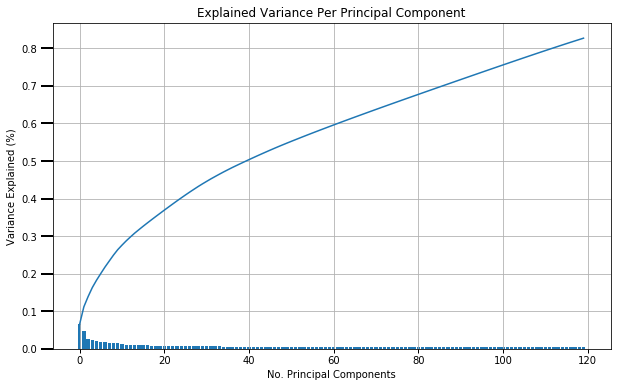

In [65]:
# Investigate the variance accounted for by each principal component.
ticks = np.arange(pca.n_components)
values = pca.explained_variance_ratio_

plt.figure(figsize = (10,6))
ax = plt.subplot(111)
cumvals = np.cumsum(values)
ax.bar(ticks,values)
ax.plot(ticks,cumvals)

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=2,length=12)

ax.set_xlabel("No. Principal Components")
ax.set_ylabel("Variance Explained (%)")
plt.grid(True)
plt.title('Explained Variance Per Principal Component')
plt.show()


I performed PCA starting with 70 components and incrementing by 10 until I broke a threshold that explains 80% variance while reducing the dimensions from 258 rows down to 120 (approximately 50% cut!).

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [66]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def plot_pca_dim(pca,feat_names,dim,features):
    '''
    For a given fitted PCA object, the given component, and a given number of features, this plots
    the variance that the particular component captures.
    '''
    fmt = lambda x: "{:.2f}%".format(x)
    sort_abs = lambda x: abs(x[0])

    names_to_weights = sorted(zip(pca.components_[dim],feat_names),key=sort_abs,reverse=True)
    names_to_weights = np.array(names_to_weights)

    nm_to_wt_df = pd.DataFrame(names_to_weights,columns=['var','feature'])
    nm_to_wt_df['var'] = nm_to_wt_df['var'].astype(float)

    return px.bar(nm_to_wt_df[:features],x='feature',y='var',
           color='var',color_continuous_scale=px.colors.sequential.Sunsetdark,
           labels = {'var': 'Variance (%)','feature':'Feature Names'},
           height=400,width=600)

feat_names = azdias_1.columns.values

Investigating and interpreting feature associations from the first three principal componentsm (As per feedback)

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_pca_dim(pca,feat_names,0,10)

<img src="fn1.PNG"/>

### Observations: Component 1

* Positive correlation between social status, household net income, and larger family homes.
* Negative correlation with smaller family homes, and interest in finances.


In [ ]:
plot_pca_dim(pca,feat_names,1,10)

<img src="fn2.PNG"/>

### Observations: Component 2

* Positive correlation between age and financially preparation.
* Negative correlations with money saving, being financially inconspicuous, investing and religion.


In [ ]:
plot_pca_dim(pca,feat_names,2,10)

<img src="fn3.PNG"/>

### Observations: Component 3

* Positive correlation between dreamful personality, family mindedness, social-mindedness, and cultural mindedness
* Negative correlations with gender, combative-minded, dominant-minded, critical-minded, and investing

In [68]:
pca.explained_variance_ratio_[:3].sum()

0.13896057932832936

### Discussion 2.3: Interpret Principal Components


* The first component seems financially-driven. It most strongly correlates social status, household income, and larger homes (positive) against smaller family homes and low financial interest.
* The second component seems personality-driven. It shows positive correlation between age and financial preparedness, and shows negative correlation against similar, more conservative personality types (financially inconspicuous, religions, traditional, dutiful, and investing).
* The third component also seems personality-driven. It shows positive correlation between dreamful, family, social, and cultural mindedness. It also shows negative correlations between gender (note value for male is lower than female = 0 vs 1), combatative, dominant, and critical mindedness.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [69]:
# scores = []
scores = [159244897.0280575,
154938714.09197658,
151151046.8259267,
148255367.92758554,
145569134.06401405,
143596882.9783832,
140515108.7902143,
139217640.80973926,
136582012.97068584,
134531378.51086235,
134215963.58263236,
130947304.45766878,
130274354.76104142,
129292724.96800065,
127316242.54892336,
125095275.16571155,
124201206.03710695,
121974132.3776415,
121556128.74119079]

In [ ]:
# start_time = time.time()
# for i in np.arange(2,21):
#     start=time.time()
#     model = KMeans(i)
#     model.fit(X_pca)
#     # Score is sum of squared distances to a sample's assigned centroid
#     new_score = abs(model.score(X_pca))
#     scores.append(new_score)
#     end = time.time()
#     print(f'Running Score for {i} Clusters: {abs(model.score(X_pca)):.3f}')
#     print(f'Time taken: {(end-start)/60:.2f} mins.')

# print(f"--- TOTAL Run time: {(time.time()-start_time)/60:.2f} mins ---")

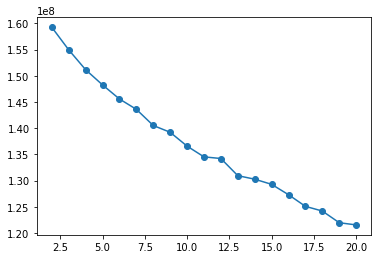

In [70]:
plt.plot(np.arange(2,21),scores,marker="o")
plt.show()

Took me a couple hours to run from 2 to 20 clusters (in batches and saved because the kernel would disconnect at times), and the model appears to have an elbow at 12 clusters which is what I'll use. (As per Feedback)

In [71]:
final_model = KMeans(12)
final_model.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [72]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
gen_preds = final_model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

Using plot of clustering scores, I decided on 12 clusters as thats where an elbow appeared to be.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [281]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',';')

In [282]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [283]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cleaned_cust = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


"movement" column being added length = 141725, should be 141725


In [284]:
# should be (141725, 256)
cleaned_cust.shape

(141725, 256)

In [285]:
cleaned_cust.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,movement,decade,cameo_intl
0,4.0,1,5,1,5,1,2,2,1,1.0,...,1,0,1,0,0,0,0,1.0,50.0,5.0
1,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,1,0,0,1.0,50.0,3.0
2,4.0,1,5,1,5,2,1,2,0,2.0,...,1,0,1,0,0,0,0,0.0,40.0,4.0
3,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,1,0,0,0,0.0,70.0,2.0
4,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,1,0,0,0,0,1.0,50.0,3.0


In [286]:
cleaned_cust.shape

(141725, 256)

In [287]:
azdias_2.shape

(798067, 257)

Missing a column.

In [288]:
for i in azdias_1.columns:
    if i not in cleaned_cust.columns:
        print(i)

GEBAEUDETYP_5.0


The imputer and scaler aren't going to work because "GEBAEUDETYP_5.0" isn't in our cleaned_cust DataFrame. This wasn't created because the "GEBAEUDETYP" column didn't have any values of 5 in our customer set since we one-hot encoded it using pd.get_dummies instead of OneHotEncoder. Adding in a column of only zeros for this missing column is an equivalent operation to not having any values of 5 for this feature.

In [289]:
GEBAEUDETYP_5 = pd.Series(np.zeros(141725))
cleaned_cust['GEBAEUDETYP_5.0'] = GEBAEUDETYP_5

In [290]:
# Reordering columns to align with original DataFrame
cols = azdias_1.columns.tolist()
cleaned_cust = cleaned_cust[cols]

In [291]:
cleaned_cust.shape

(141725, 257)

Fixing issue of apply the same clean_data function applied on the general demographic data. not redefine the clean_data function (As per feedback)

### Imputing

In [262]:
#np.where(cleaned_cust.values >= np.finfo(np.float64).max)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


(array([], dtype=int64), array([], dtype=int64))

In [264]:
cleaned_cust.shape

(141725, 257)

In [293]:
imputed = med_imp.transform(cleaned_cust)
standardized = scaler.transform(imputed)

In [294]:
standardized.shape

(141725, 257)

### PCA

In [295]:
X_pca_cust = pca.transform(cleaned_cust)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [142]:
X_pca_cust.shape

(141725, 120)

### Clustering

In [143]:
preds = final_model.predict(X_pca_cust)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [144]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

df_preds_cust = pd.DataFrame(preds,columns=['cust_preds'])
df_preds_gen =  pd.DataFrame(gen_preds,columns=['gen_preds'])

In [145]:
prop_cust = df_preds_cust['cust_preds'].value_counts().sort_index()/ \
                sum(df_preds_cust['cust_preds'].value_counts())
prop_gen = df_preds_gen['gen_preds'].value_counts().sort_index()/ \
                sum(df_preds_gen['gen_preds'].value_counts())

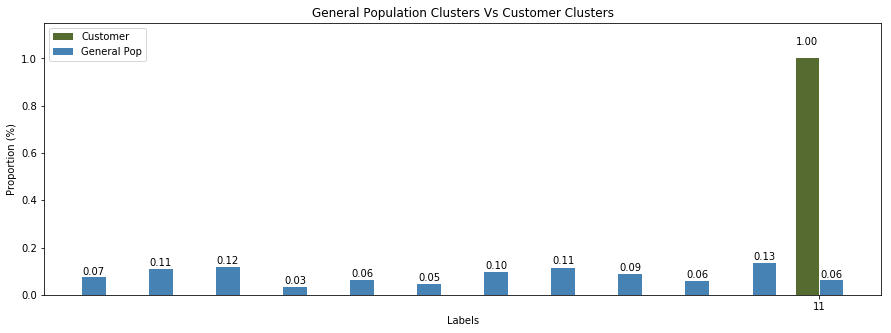

In [146]:
fig,ax = plt.subplots(figsize=(15,5))
width = 0.35

cust = ax.bar(prop_cust.index-.51*width, prop_cust, width, color='darkolivegreen')
gen = ax.bar(prop_gen.index+.51*width, prop_gen, width, color='steelblue')


ax.set_ylabel('Proportion (%)')
ax.set_xlabel('Labels')
ax.set_title('General Population Clusters Vs Customer Clusters')
ax.set_xticks(prop_cust.index)
ax.set_ylim(top=max(prop_cust.append(prop_gen))*1.15)
ax.legend(('Customer','General Pop'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % float(height),
                ha='center', va='bottom')

autolabel(cust)
autolabel(gen)

The most outstanding values are customers are Overrepresented in clusters: 3 and 4 (by 3x values)

Customers are more underrepresented in clusters: 6, 12, 19, and 20 (by 4x values)


In [ ]:
def plot_scaled_comparison(df_sample, kmeans, cluster):
    '''
    Takes performs the PCA inverse_transform of a selected cluster from our trained model to obtain 
        the scaled feature weights. This helps us interpret who belongs in a given cluster.
    '''
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
        pca.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(
        columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

In [ ]:
# Listing which clusters affected Cluster #3
centroid = final_model.cluster_centers_[3]
centroid_df = pd.DataFrame(centroid,columns=['pca_weights'])

# Sorting the centroid in descending absolute value order
    # Note indexes correspond to principal components
centroid_df.reindex(centroid_df.abs().sort_values('pca_weights',ascending=False).index).head()

In [ ]:
plot_scaled_comparison(azdias_1, final_model, 3)

In [ ]:
# Listing which clusters affected Cluster #4
centroid = final_model.cluster_centers_[4]
centroid_df = pd.DataFrame(centroid,columns=['pca_weights'])

# Sorting the centroid in descending absolute value order
    # Note indexes correspond to principal components
centroid_df.reindex(centroid_df.abs().sort_values('pca_weights',ascending=False).index).head()

In [ ]:
plot_scaled_comparison(azdias_1, final_model, 4)

### Discussion 3.3: Compare Customer Data to Demographics Data

I'll be honest, I've done 24 total hours of work on this final over three days, with the computations shutting my computer down numerous times, having to transfer it over to digitalU jupyter, and redo most of the work because of version incompatibilities. Add in losing connection to the Kernal numerous times during KMeans cluster scoring and having to REDO multiple times has fried my brain.

It appears Cluster 3 and 4 were highly represented by Lebensphase (Life stage/financial scale) customers. At this point, I'll be honest I need ALOT more practice working with data to get more prificient than a (frankly) grueling 13 week bootcamp that highly condenced some advanced stuff, but my general impression from this last review of data is the existing customer population lies higher in the the age and wealth range and the company could reach out better to the less affluent.